In [1]:
import time, matplotlib, sklearn

# visualizatoin 
import matplotlib.pyplot as plt 

# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

# learning
from sklearn.linear_model import LogisticRegression

# the data intro has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.21.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.2   Your version: %s" % sklearn.__version__)

pandas        Tested version: 2.0.3   Your version: 1.5.3
numpy         Tested version: 1.21.5  Your version: 1.24.2
matplotlib    Tested version: 3.5.3   Your version: 3.8.0
scikit-learn  Tested version: 1.2.2   Your version: 1.3.0


# Load data
If you put the data set in the same folder as this notebook, you can use the following code to load the data set. 

In [2]:
# description
description = pd.read_csv('WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('training_v2.csv')

df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


The dataset contains many different variables, including:

#### Target variable
* *hospital_death*: 'Whether the patient died during this hospitalization.

#### Identifiers
* *patient_id*: Unique identifier associated with a patient
* *encounter_id*: Unique identifier associated with a patient unit stay
* *hospital_id*: Unique identifier associated with a hospital
* *icu_id*: A unique identifier for the unit to which the patient was admitted

#### Demographics
* *age*: The age of the patient on unit admission.
* *bmi*: The body mass index of the person on unit admission.
* *ethnicity*: The common national or cultural tradition which the person belongs to.
* *gender*: The genotypical sex of the patient.
* *height*: The height of the person on unit admission

#### Health indicators
A few examples:
* *elective_surgery*: Whether the patient was admitted to the hospital for an elective surgical operation
* *h1_diasbp_invasive_max*: The patient's highest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *h1_diasbp_invasive_min*: The patient's lowest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *gcs_verbal_apache*: The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score
* *immunosuppression*: Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).

In [3]:
# you can retrieve the description of a variable in the data set from the description dictionary as follows
description_dict['immunosuppression']

{'Category': 'APACHE comorbidity',
 'Unit of Measure': 'None',
 'Data Type': 'binary',
 'Description': 'Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).',
 'Example': '1'}

# Pre-processing
This is a real-world data set, meaning that it is **messy**. Two key difficulties are categorial features and missing values.

> **To avoid information leakage, any pre-processing steps must be based on the training data only.** For example, when we compute the mean, this must be computed based on the training data set.

### Categorical Features
Many (implementations of) machine learning algorithms cannot handle categorical features automatically. This is often dealt with through *one-hot-encoding*, where each category of a feature is transformed into a binary feature.

When a feature contains many categories, this results in a very sparse data set with many features. As such, it can be worthwile to use domain expertise to merge particular categories in order to reduce the number of one-hot-encoded features.

### Missing Values
The data set contains a lot of missing values (around 35% of the values is missing). There are several ways to deal with this, some ideas to try:

* Replace missing values with the mean (numerical features) or median (categorical features), e.g., using [`SimpleImputer`](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation).
* Drop features with many missing values.
* Model-based imputation strategies, such as [KNNImputer](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation).
* Domain-knowledge inspired replacement. For example, for features related to medical measurements, it is expected that the entered data is abnormal in some way. As such, replacing by the mean or median can paint a skewed picture. One way to deal with this would be to identify a normal range for different measurements, based on domain expertise. *Note: this is a very time consuming strategy which we do not necessarily recommend in the time span of this project.*

We encourage you to try several approaches and see what works best.

## Example of  Minimal Pre-Processing
Below you can find an example of pre-processing the data set for classification. We showcase both 'manual' pre-processing steps through `pandas` as well as a (small) scikit-learn `Pipeline`. Feel free to use whatever you are most comfortable with in your project.

In [4]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

In [5]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("imputer", SimpleImputer(strategy="mean")),
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"))])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])
# pipeline
prep_pipeline.fit(X_train, y_train)
display(prep_pipeline) # disply preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('imputer', SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000209E9C7C400>),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000209E9BE26E0>)])

Time: 1.72s
Train set: 73370 rows, 184 columns
Validation set: 9171 rows, 184 columns
Test set: 9172 rows, 184 columns


## Simple Logistic Regression Model
We can now train a simple logistic regression model.

> **Warning**. The following code will lead to a convergence warning. To solve this "issue", you can increase `max_iter` and/or apply a `sklearn.preprocessing.StandardScaler()`. However, the model still performance reasonably well even without convergence.

In [6]:
start_time = time.time()

# train logistic regression model
lr = LogisticRegression(penalty='l1', solver='saga')
lr.fit(X_train, y_train)

print("Time: %.2fs" % (time.time() - start_time))

Time: 22.16s


c:\Users\20210295\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# APACHE IV Scores
APACHE ("Acute Physiology and Chronic Health Evaluation") is a scoring system assessing severity of illness and prognoses of ICU patients. The scoring system has been improved over time, with APACHE II being released in 1985, APACHE III in 1991, and finally APACHE IV in 2006. APACHE IV has been evaluated and validated in patients for mortality outcome. 

In the dataset, the *apache_4a_hospital_death_prob* column corresponds to the APACHE IV probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.
* `-1` means the score couldn't be calculated for some reason. In particular, the patient encounter could have been a re-admission. 
* `NaN` indicates a missing score, due to e.g., a missing covariate that made it impossible to compute the score. 


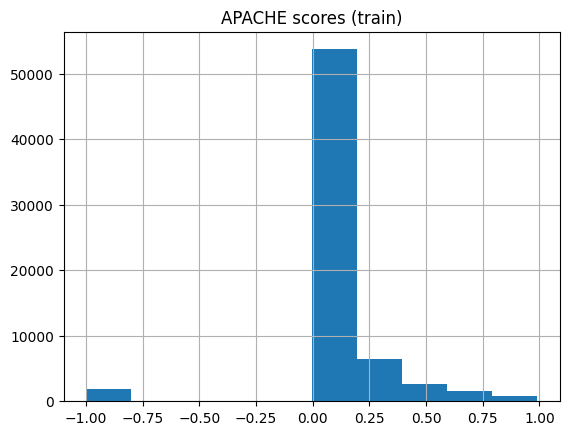

In [7]:
# histogram
y_apache_train.hist()
plt.title("APACHE scores (train)")
plt.show()

In [56]:
df

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [8]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import lightgbm as lgb

In [10]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6328, number of negative: 67042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18304
[LightGBM] [Info] Number of data points in the train set: 73370, number of used features: 181
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086248 -> initscore=-2.360335
[LightGBM] [Info] Start training from score -2.360335


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [11]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.9463
Testing accuracy 0.9297


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

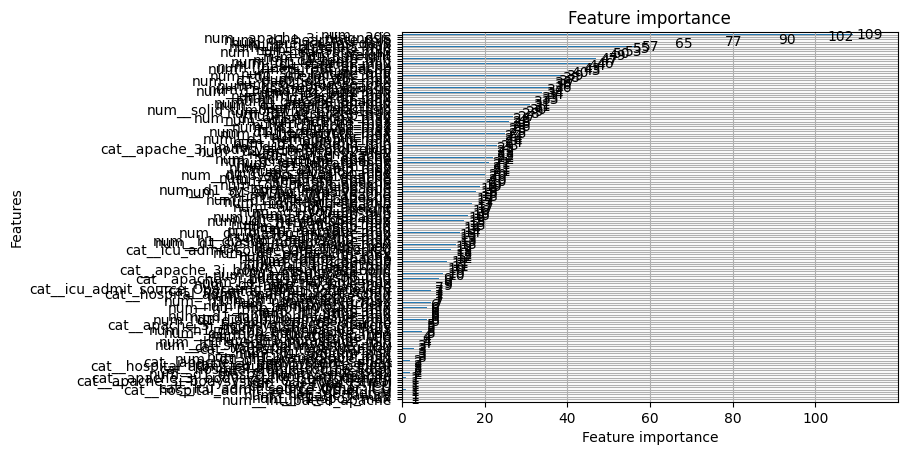

In [23]:
lgb.plot_importance(model)

In [12]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
X_train

,num__age,num__bmi,num__elective_surgery,num__height,num__pre_icu_los_days,num__weight,num__albumin_apache,num__apache_2_diagnosis,num__apache_3j_diagnosis,num__apache_post_operative,...,cat__apache_3j_bodysystem_Genitourinary,cat__apache_3j_bodysystem_Gynecological,cat__apache_3j_bodysystem_Hematological,cat__apache_3j_bodysystem_Metabolic,cat__apache_3j_bodysystem_Musculoskeletal/Skin,cat__apache_3j_bodysystem_Neurological,cat__apache_3j_bodysystem_Respiratory,cat__apache_3j_bodysystem_Sepsis,cat__apache_3j_bodysystem_Trauma,cat__apache_3j_bodysystem_nan
0,86.000000,28.168975,0.0,170.2,0.000000,81.6,2.90288,301.00000,408.020000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,72.000000,36.635088,0.0,170.1,0.088889,106.0,2.90288,124.00000,305.010000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36.000000,27.459684,0.0,162.6,0.044444,72.6,2.90288,122.00000,703.030000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,60.000000,21.977351,0.0,181.0,0.213194,72.0,2.90288,305.00000,901.030000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27.000000,19.960244,0.0,177.8,0.052083,63.1,2.50000,113.00000,501.040000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,16.000000,22.378743,1.0,165.1,0.004167,61.0,2.90288,219.00000,1504.040000,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
73366,70.000000,29.475309,1.0,180.0,0.560417,95.5,2.90288,185.43556,0.250000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
73367,72.000000,30.827304,1.0,187.0,0.236806,107.8,2.90288,202.00000,1205.010000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73368,46.000000,61.339079,0.0,167.6,0.000000,172.3,3.40000,102.00000,206.010000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Feature Selection using Anova

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import (
    f_classif,
    SelectFpr,
    SelectKBest,
)
from sklearn.model_selection import train_test_split

univariate = f_classif(X_train, y_train)

Text(0.5, 1.0, 'Anova')

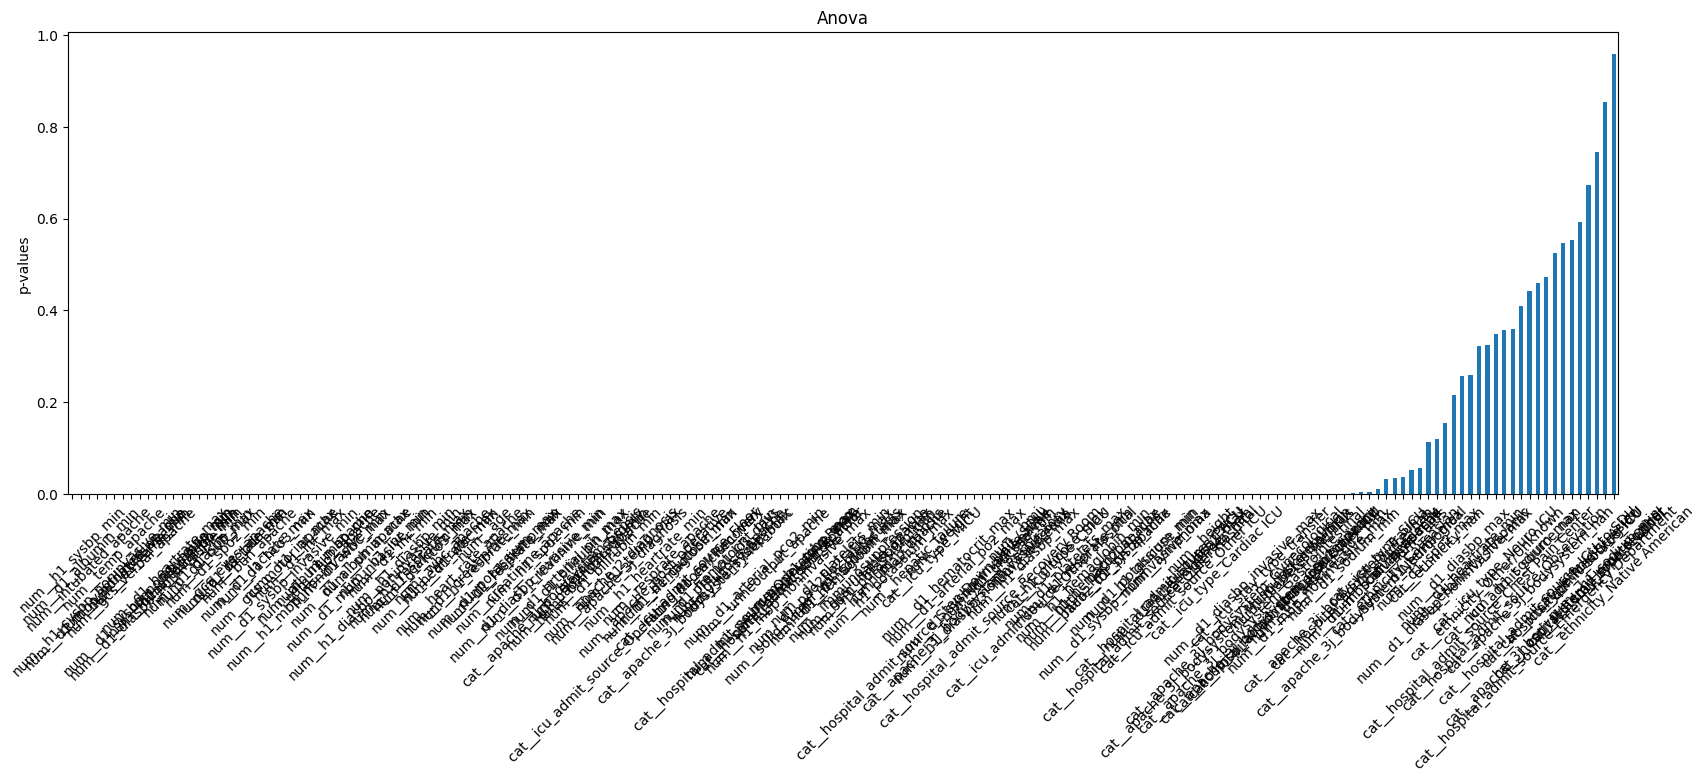

In [42]:
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=True).plot.bar(figsize=(20, 6), rot=45)
plt.ylabel("p-values")
plt.title("Anova")

In [45]:
sel = SelectFpr(f_classif, alpha=0.005).fit(X_train, y_train)
X_train.columns[sel.get_support()]

Index(['num__age', 'num__bmi', 'num__elective_surgery', 'num__height',
       'num__pre_icu_los_days', 'num__weight', 'num__albumin_apache',
       'num__apache_2_diagnosis', 'num__apache_3j_diagnosis',
       'num__apache_post_operative',
       ...
       'cat__icu_type_MICU', 'cat__apache_3j_bodysystem_Gastrointestinal',
       'cat__apache_3j_bodysystem_Genitourinary',
       'cat__apache_3j_bodysystem_Gynecological',
       'cat__apache_3j_bodysystem_Metabolic',
       'cat__apache_3j_bodysystem_Musculoskeletal/Skin',
       'cat__apache_3j_bodysystem_Neurological',
       'cat__apache_3j_bodysystem_Respiratory',
       'cat__apache_3j_bodysystem_Sepsis', 'cat__apache_3j_bodysystem_Trauma'],
      dtype='object', length=155)

In [47]:
selected_features = X_train.columns[sel.get_support()]
X_train_selected = X_train[selected_features]
X_train_selected

,num__age,num__bmi,num__elective_surgery,num__height,num__pre_icu_los_days,num__weight,num__albumin_apache,num__apache_2_diagnosis,num__apache_3j_diagnosis,num__apache_post_operative,...,cat__icu_type_MICU,cat__apache_3j_bodysystem_Gastrointestinal,cat__apache_3j_bodysystem_Genitourinary,cat__apache_3j_bodysystem_Gynecological,cat__apache_3j_bodysystem_Metabolic,cat__apache_3j_bodysystem_Musculoskeletal/Skin,cat__apache_3j_bodysystem_Neurological,cat__apache_3j_bodysystem_Respiratory,cat__apache_3j_bodysystem_Sepsis,cat__apache_3j_bodysystem_Trauma
0,86.000000,28.168975,0.0,170.2,0.000000,81.6,2.90288,301.00000,408.020000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,72.000000,36.635088,0.0,170.1,0.088889,106.0,2.90288,124.00000,305.010000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36.000000,27.459684,0.0,162.6,0.044444,72.6,2.90288,122.00000,703.030000,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,60.000000,21.977351,0.0,181.0,0.213194,72.0,2.90288,305.00000,901.030000,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27.000000,19.960244,0.0,177.8,0.052083,63.1,2.50000,113.00000,501.040000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,16.000000,22.378743,1.0,165.1,0.004167,61.0,2.90288,219.00000,1504.040000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
73366,70.000000,29.475309,1.0,180.0,0.560417,95.5,2.90288,185.43556,0.250000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73367,72.000000,30.827304,1.0,187.0,0.236806,107.8,2.90288,202.00000,1205.010000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73368,46.000000,61.339079,0.0,167.6,0.000000,172.3,3.40000,102.00000,206.010000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [52]:
feature_scores = sel.scores_

feature_scores_dict = {feature: score for feature, score in zip(selected_features, feature_scores)}
sorted_features = sorted(feature_scores_dict.items(), key=lambda x: x[1], reverse=True)


for feature, score in sorted_features:
    print(f"{feature}: {score}")


num__gcs_motor_apache: 6230.257108652515
num__d1_sodium_min: 5706.361138234009
num__d1_sodium_max: 5624.3613897534315
num__gcs_eyes_apache: 5169.197986615673
num__gcs_verbal_apache: 4348.908925438195
num__wbc_apache: 3981.283529418283
num__h1_diasbp_min: 3391.0500196144676
num__h1_diasbp_noninvasive_min: 3343.5177648952504
num__d1_sysbp_noninvasive_max: 3304.02646059584
num__h1_heartrate_min: 3105.0643031158816
num__d1_resprate_min: 2889.084151336449
num__d1_sysbp_invasive_max: 2854.1855575969466
num__d1_heartrate_max: 2404.8508203303345
num__d1_mbp_invasive_min: 2388.072040270938
num__d1_glucose_max: 2360.1660922974534
num__immunosuppression: 2313.532788446796
num__intubated_apache: 2264.312342853041
num__d1_glucose_min: 2253.3428340247424
num__d1_mbp_max: 2120.1636384233248
num__bun_apache: 1991.4699230410229
num__d1_calcium_min: 1757.8099535674933
num__d1_inr_min: 1720.1257016099166
num__urineoutput_apache: 1694.4638803835755
num__d1_bilirubin_min: 1520.4165781817485
num__d1_albumin

In [118]:
df_features = pd.DataFrame(sorted_features, columns=['Feature', 'Score'])

df_imp_feat = df_features.iloc[1:40]
imp_feat_lst = df_imp_feat['Feature'].tolist()
imp_feat_lst




['num__d1_sodium_min',
 'num__d1_sodium_max',
 'num__gcs_eyes_apache',
 'num__gcs_verbal_apache',
 'num__wbc_apache',
 'num__h1_diasbp_min',
 'num__h1_diasbp_noninvasive_min',
 'num__d1_sysbp_noninvasive_max',
 'num__h1_heartrate_min',
 'num__d1_resprate_min',
 'num__d1_sysbp_invasive_max',
 'num__d1_heartrate_max',
 'num__d1_mbp_invasive_min',
 'num__d1_glucose_max',
 'num__immunosuppression',
 'num__intubated_apache',
 'num__d1_glucose_min',
 'num__d1_mbp_max',
 'num__bun_apache',
 'num__d1_calcium_min',
 'num__d1_inr_min',
 'num__urineoutput_apache',
 'num__d1_bilirubin_min',
 'num__d1_albumin_min',
 'num__d1_temp_min',
 'num__d1_potassium_max',
 'num__d1_arterial_ph_max',
 'num__h1_sysbp_min',
 'num__albumin_apache',
 'num__h1_spo2_min',
 'num__fio2_apache',
 'num__h1_inr_max',
 'num__d1_calcium_max',
 'num__d1_mbp_noninvasive_min',
 'num__ph_apache',
 'num__h1_mbp_noninvasive_min',
 'num__d1_potassium_min',
 'num__d1_arterial_ph_min',
 'num__h1_mbp_min']

In [119]:
df_split = X_train[imp_feat_lst]
df_split['hospital_death'] = y_train
df_split.corr()


C:\Users\20210295\AppData\Local\Temp\ipykernel_7440\1699795181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_split['hospital_death'] = y_train


,num__d1_sodium_min,num__d1_sodium_max,num__gcs_eyes_apache,num__gcs_verbal_apache,num__wbc_apache,num__h1_diasbp_min,num__h1_diasbp_noninvasive_min,num__d1_sysbp_noninvasive_max,num__h1_heartrate_min,num__d1_resprate_min,...,num__fio2_apache,num__h1_inr_max,num__d1_calcium_max,num__d1_mbp_noninvasive_min,num__ph_apache,num__h1_mbp_noninvasive_min,num__d1_potassium_min,num__d1_arterial_ph_min,num__h1_mbp_min,hospital_death
num__d1_sodium_min,1.000000,0.828666,-0.075985,-0.103340,-0.047503,-0.014647,-0.009677,0.038342,-0.037031,-0.049099,...,-0.001117,-0.028968,-0.022310,-0.009115,0.014825,-0.009063,-0.056528,0.017227,-0.013525,-0.009636
num__d1_sodium_max,0.828666,1.000000,-0.170919,-0.199699,0.016956,-0.054749,-0.044236,0.027945,-0.000605,-0.071717,...,0.034176,-0.003194,-0.007121,-0.062723,-0.035302,-0.049609,-0.160510,-0.075367,-0.059414,-0.005250
num__gcs_eyes_apache,-0.075985,-0.170919,1.000000,0.778593,-0.103572,0.082468,0.074630,-0.021185,-0.045168,0.070389,...,-0.099180,-0.037158,0.081816,0.135265,0.045447,0.099154,0.076899,0.094472,0.106929,-0.001424
num__gcs_verbal_apache,-0.103340,-0.199699,0.778593,1.000000,-0.115994,0.092998,0.082345,-0.021462,-0.064671,0.054586,...,-0.098120,-0.030654,0.081053,0.145736,0.013910,0.107160,0.084965,0.060983,0.116601,-0.000896
num__wbc_apache,-0.047503,0.016956,-0.103572,-0.115994,1.000000,-0.091975,-0.088749,-0.054128,0.137865,0.027877,...,0.063308,0.050343,-0.074482,-0.100188,-0.073706,-0.105188,0.027886,-0.096419,-0.107931,0.001306
num__h1_diasbp_min,-0.014647,-0.054749,0.082468,0.092998,-0.091975,1.000000,0.962405,0.304821,0.109652,0.078500,...,-0.040029,-0.095758,0.187590,0.542405,0.078327,0.846361,-0.058963,0.108183,0.863789,0.003892
num__h1_diasbp_noninvasive_min,-0.009677,-0.044236,0.074630,0.082345,-0.088749,0.962405,1.000000,0.296005,0.102001,0.065768,...,-0.039523,-0.100118,0.189177,0.551398,0.079145,0.864667,-0.063625,0.104456,0.848185,0.004853
num__d1_sysbp_noninvasive_max,0.038342,0.027945,-0.021185,-0.021462,-0.054128,0.304821,0.296005,1.000000,-0.088342,-0.061809,...,-0.006493,-0.058992,0.147335,0.241127,0.027987,0.409597,-0.016457,0.029540,0.416351,0.004337
num__h1_heartrate_min,-0.037031,-0.000605,-0.045168,-0.064671,0.137865,0.109652,0.102001,-0.088342,1.000000,0.179449,...,0.033336,0.041796,-0.097926,-0.032533,-0.048182,0.019764,-0.067438,-0.049535,0.024413,0.007276
num__d1_resprate_min,-0.049099,-0.071717,0.070389,0.054586,0.027877,0.078500,0.065768,-0.061809,0.179449,1.000000,...,0.006278,0.027919,0.043865,0.141065,0.007450,0.071636,-0.012163,0.039529,0.080258,-0.005446


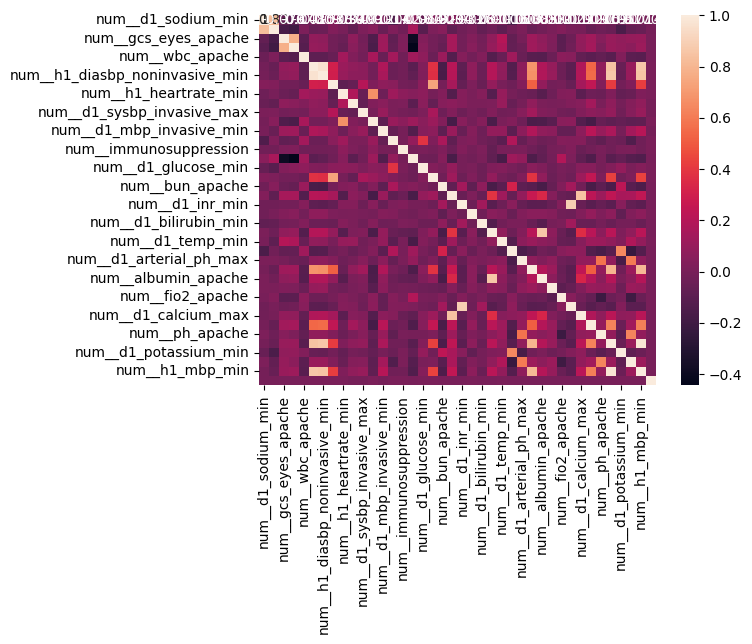

In [120]:
import seaborn as sn
import matplotlib.pyplot as plt

corr_matrix = df_split.corr()

sn.heatmap(corr_matrix, annot=True)
plt.show()

In [124]:
correlation_list = corr_matrix.unstack().sort_values(ascending=False)
correlation_list_filtered = correlation_list[correlation_list != 1]

correlation_list_filtered[:20]


num__h1_mbp_noninvasive_min     num__h1_mbp_min                   0.976437
num__h1_mbp_min                 num__h1_mbp_noninvasive_min       0.976437
num__h1_diasbp_min              num__h1_diasbp_noninvasive_min    0.962405
num__h1_diasbp_noninvasive_min  num__h1_diasbp_min                0.962405
num__d1_inr_min                 num__h1_inr_max                   0.887532
num__h1_inr_max                 num__d1_inr_min                   0.887532
num__h1_mbp_noninvasive_min     num__h1_diasbp_noninvasive_min    0.864667
num__h1_diasbp_noninvasive_min  num__h1_mbp_noninvasive_min       0.864667
num__h1_diasbp_min              num__h1_mbp_min                   0.863789
num__h1_mbp_min                 num__h1_diasbp_min                0.863789
num__d1_albumin_min             num__albumin_apache               0.860060
num__albumin_apache             num__d1_albumin_min               0.860060
num__h1_diasbp_noninvasive_min  num__h1_mbp_min                   0.848185
num__h1_mbp_min          